# Diagnóstico Automatizado de Cardiomegalia 
Esse programa fará o diagnóstico de cardiomegalia a partir de uma imagem de raio-x. Os exemplos de teste foram todos coletados do Kaggle em dominio público e podem ser acessados integralmente em https://www.kaggle.com/datasets/rahimanshu/cardiomegaly-disease-prediction-using-cnn. 

# Temporário

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib 
from tensorflow.python.framework import ops
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
train_set = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/Pc/Desktop/CardiomegaliaAI/train',             # path da pasta raiz
    labels='inferred',     # Designa automaticamente as labels com base nos nomes das pastas
    label_mode='int',      # Classificações como inteiros (0 ou 1)
    image_size=(128, 128), # Garante que todas as imagens estejam no mesmo tamanho
    batch_size=64 ,        # Número de imagens em cada batch
    color_mode='grayscale' # Garante que as imagens são carregadas em escala de cinza
)

test_set = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/Pc/Desktop/CardiomegaliaAI/test',              # path da pasta raiz
    labels='inferred',     # Designa automaticamente as labels com base nos nomes das pastas
    label_mode='int',      # Classificações como inteiros (0 ou 1)
    image_size=(128, 128), # Garante que todas as imagens estejam no mesmo tamanho
    batch_size=64,         # Número de imagens em cada batch
    color_mode='grayscale' # Garante que as imagens são carregadas em escala de cinza
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescale pixels to [0, 1]
    
    # If your images are grayscale and you want to convert to RGB (3 channels):
    tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)), 
    
    # Additional augmentations
    tf.keras.layers.RandomRotation(0.1),              # Random rotation (10% of the image)
    tf.keras.layers.RandomZoom(0.1),                  # Random zoom (10% of the image)
    tf.keras.layers.RandomContrast(0.2)              # Random contrast adjustment
])
base_model = tf.keras.applications.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True

lambda_ = 1.44e-01
learning_rate = 9.54e-05

Found 4438 files belonging to 2 classes.
Found 1114 files belonging to 2 classes.


## 1. Os dados
Os dados estão separados em um grupo de treinamento e um grupo de teste, ambos divididos em casos positivos e casos negativos em proporções de 1:1 para evitar algum viés na classificação. Cada imagem é de tamanho 128x128 e estão todas em grayscale (128x128x1). Vamos começar então transformando as imagens em arrays que possamos processar.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib 
from tensorflow.python.framework import ops
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_set = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/Pc/Desktop/CardiomegaliaAI/train',             # path da pasta raiz
    labels='inferred',     # Designa automaticamente as labels com base nos nomes das pastas
    label_mode='int',      # Classificações como inteiros (0 ou 1)
    image_size=(128, 128), # Garante que todas as imagens estejam no mesmo tamanho
    batch_size=64 ,        # Número de imagens em cada batch
    color_mode='grayscale' # Garante que as imagens são carregadas em escala de cinza
)

test_set = tf.keras.utils.image_dataset_from_directory(
    '/mnt/c/Users/Pc/Desktop/CardiomegaliaAI/test',              # path da pasta raiz
    labels='inferred',     # Designa automaticamente as labels com base nos nomes das pastas
    label_mode='int',      # Classificações como inteiros (0 ou 1)
    image_size=(128, 128), # Garante que todas as imagens estejam no mesmo tamanho
    batch_size=64,         # Número de imagens em cada batch
    color_mode='grayscale' # Garante que as imagens são carregadas em escala de cinza
)

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),  # Rescale pixels to the range [0,1]
        tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)) 
    ])

base_model = tf.keras.applications.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True

2024-12-21 19:39:59.993887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734820800.174489     243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734820800.225161     243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 19:40:00.625145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4438 files belonging to 2 classes.


I0000 00:00:1734820808.921244     243 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1114 files belonging to 2 classes.
Image batch shape: (64, 128, 128, 1)
Label batch shape: (64,)


2024-12-21 19:40:11.369866: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vamos agora analisar alguns casos de exemplo:

2024-12-19 11:03:35.637427: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


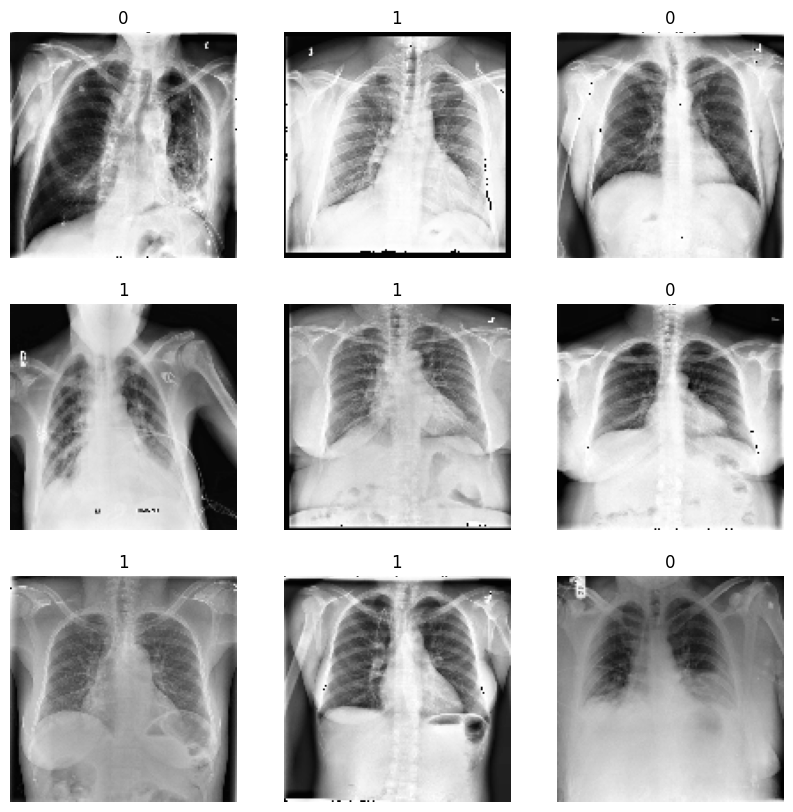

In [2]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

## 2. O modelo
Vamos treinar uma Rede Neural Convolucional para classificar os pacientes em duas categorias: 1 se o paciente tiver cardiomegalia ou 0 caso contrário.

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.4943 - loss: 20.0710 - val_accuracy: 0.5377 - val_loss: 0.6897
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5618 - loss: 0.6759 - val_accuracy: 0.5512 - val_loss: 0.6911
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6252 - loss: 0.6454 - val_accuracy: 0.5530 - val_loss: 0.7112
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6807 - loss: 0.5834 - val_accuracy: 0.5628 - val_loss: 0.7307
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7150 - loss: 0.5275 - val_accuracy: 0.5583 - val_loss: 0.7895
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7720 - loss: 0.4653 - val_accuracy: 0.5718 - val_loss: 0.8325
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8078 - loss: 0.3958 - val_accuracy: 0.5969 - val_loss: 0.9010
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8572 - loss: 0.3213 - val_accuracy: 0.5943 - 

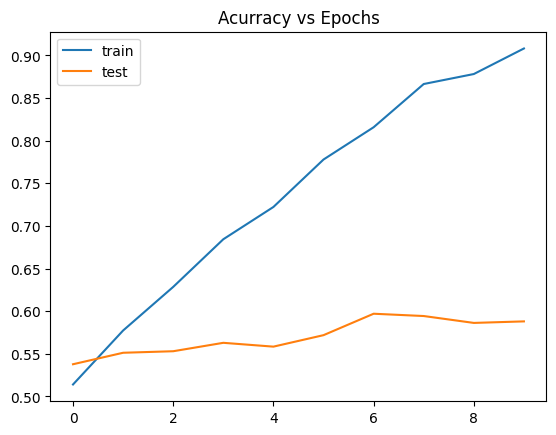

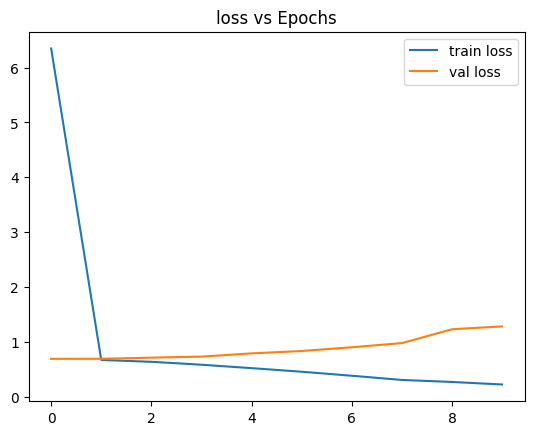

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_set, validation_data=test_set, epochs=10)

test_loss, test_acc = model.evaluate(test_set, verbose=2)

# plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Acurracy vs Epochs') 
plt.show()

# plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('loss vs Epochs') 
plt.show()

Perceba que temos um sinal de overfitting: a performance do modelo no train_set é muito superior à performance do test_set. Vamos adicionar uma layer de preprocessamento para ajustar os valores dos pixeis para valores de 0 a 1. Vamos passar a usar um modelo pré-treinado.

In [15]:
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),  # Rescale pixels to the range [0,1]
        tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)) 
    ])

base_model = tf.keras.applications.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True

In [ ]:
lambda_ = 0.07


model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])



adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=10)
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_set, verbose=2)


# plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Acurracy vs Epochs') 
plt.show()

# plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('loss vs Epochs') 
plt.show()
##############################################################################

Epoch 1/10


KeyboardInterrupt: 

Obtivemos uma melhora significativa apenas de incluir o modelo pré-treinado. Agora, vamos tentar otimizar os parâmetros.

In [10]:
results = []
for i in range (20):
    r1 = -2*np.random.rand() - 3 # r1 in [10^-5, 10^-3]
    r2 = -2*np.random.rand() - 3 # r2 in [10^-5, 10^-3]
    learning_rate = 10**r1
    lambda_ = 10**r2
    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])



    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_set, validation_data=test_set, epochs=5, verbose=0)
    test_loss, test_acc = model.evaluate(test_set, verbose=2)

    results.append({
        'learning_rate' : learning_rate,
        'lambda' : lambda_,
        'loss' : test_loss,
        'acc' : test_acc
    })





18/18 - 0s - 23ms/step - accuracy: 0.6427 - loss: 0.8063
18/18 - 0s - 23ms/step - accuracy: 0.8016 - loss: 0.8854
18/18 - 0s - 22ms/step - accuracy: 0.8142 - loss: 1.0356
18/18 - 0s - 22ms/step - accuracy: 0.8088 - loss: 1.2750
18/18 - 0s - 22ms/step - accuracy: 0.7549 - loss: 1.7351
18/18 - 0s - 21ms/step - accuracy: 0.8142 - loss: 1.0879
18/18 - 0s - 22ms/step - accuracy: 0.8241 - loss: 0.9269
18/18 - 0s - 22ms/step - accuracy: 0.8196 - loss: 0.9425
18/18 - 0s - 22ms/step - accuracy: 0.8160 - loss: 1.2697
18/18 - 0s - 22ms/step - accuracy: 0.8205 - loss: 1.2389
18/18 - 0s - 23ms/step - accuracy: 0.8106 - loss: 1.1163
18/18 - 0s - 22ms/step - accuracy: 0.8106 - loss: 1.5175
18/18 - 0s - 22ms/step - accuracy: 0.8169 - loss: 1.1741
18/18 - 0s - 22ms/step - accuracy: 0.8151 - loss: 1.2752
18/18 - 0s - 22ms/step - accuracy: 0.7989 - loss: 1.3087
18/18 - 0s - 22ms/step - accuracy: 0.7864 - loss: 1.6562
18/18 - 0s - 22ms/step - accuracy: 0.8034 - loss: 1.4022
18/18 - 0s - 22ms/step - accura

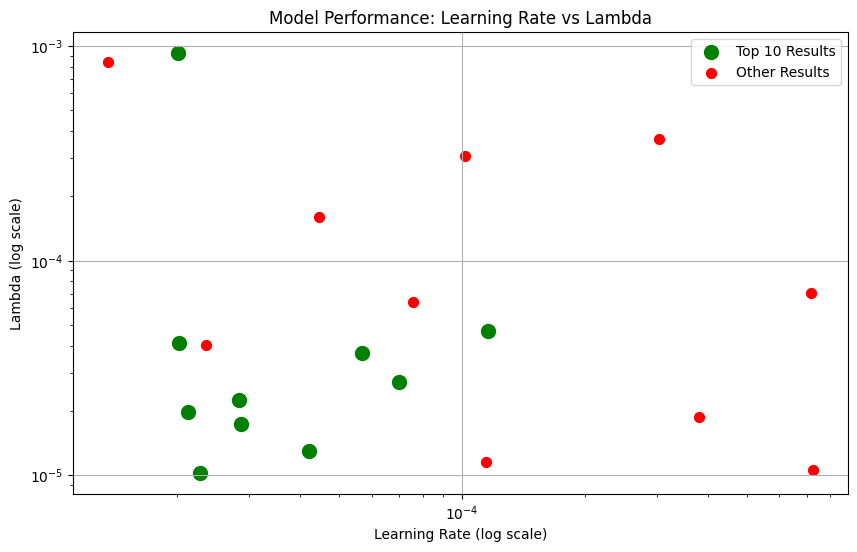

In [15]:
# Sort results by accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['acc'], reverse=True)

# Separate the 10 best results
best_results = sorted_results[:10]
other_results = sorted_results[10:]

# Prepare data for plotting
# Extract learning rates and lambdas
learning_rates_best = [r['learning_rate'] for r in best_results]
lambdas_best = [r['lambda'] for r in best_results]
accuracy_best = [r['acc'] for r in best_results]

learning_rates_other = [r['learning_rate'] for r in other_results]
lambdas_other = [r['lambda'] for r in other_results]
accuracy_other = [r['acc'] for r in other_results]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the 10 best results in green
plt.scatter(learning_rates_best, lambdas_best, c='green', s=100, label='Top 10 Results')
# Plot the other results in red
plt.scatter(learning_rates_other, lambdas_other, c='red', s=50, label='Other Results')

# Set plot attributes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Lambda (log scale)')
plt.title('Model Performance: Learning Rate vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

Perceba que a maior parte dos 10 melhores resultados estão no retângulo [10**-5, 10**-4]x[10**-5, 10**-4]. Por simplicidade, vamos escolher o valor que deu a melhor precisão do modelo final.

In [19]:
best_result = max(results, key=lambda x: x['acc'])
print(best_result)

{'learning_rate': 1.507679105287575e-05, 'lambda': 2.9347987564874392e-05, 'loss': 0.6862053871154785, 'acc': 0.809694766998291}


In [19]:
learning_rate = 1.51e-05
lambda_ = 2.93e-05

Vamos verificar o resultado.

In [7]:
model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/20


I0000 00:00:1734557476.337225    2539 service.cc:148] XLA service 0x7f9ee4003350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734557476.337633    2539 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-18 18:31:16.778212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734557478.516324    2539 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-18 18:31:20.755416: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12291', 220 bytes spill stores, 576 bytes spill loads

2024-12-18 18:31:21.437904: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15350', 496 

 2/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4531 - loss: 0.7284 - precision: 0.4470 - recall: 0.7143  

I0000 00:00:1734557496.739211    2539 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5359 - loss: 0.6981 - precision: 0.5277 - recall: 0.6685

2024-12-18 18:31:45.505009: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12291_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-18 18:31:45.926249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12291', 16 bytes spill stores, 16 bytes spill loads

2024-12-18 18:31:45.993738: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12291', 68 bytes spill stores, 68 bytes spill loads

2024-12-18 18:31:46.353108: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15350', 24 bytes spill stores, 24 bytes spill loads

2024-12-18 18:31:46.477091: I external/local_xla/xla/str

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5364 - loss: 0.6980 - precision: 0.5282 - recall: 0.6677

2024-12-18 18:31:59.898860: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1075_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-18 18:32:00.144837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1075', 16 bytes spill stores, 16 bytes spill loads

2024-12-18 18:32:00.227440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1075', 132 bytes spill stores, 132 bytes spill loads



70/70 ━━━━━━━━━━━━━━━━━━━━ 60s 375ms/step - accuracy: 0.5369 - loss: 0.6978 - precision: 0.5287 - recall: 0.6670 - val_accuracy: 0.5978 - val_loss: 0.6698 - val_precision: 0.6730 - val_recall: 0.3806
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6942 - loss: 0.6300 - precision: 0.6687 - recall: 0.7461 - val_accuracy: 0.6382 - val_loss: 0.6408 - val_precision: 0.6816 - val_recall: 0.5189
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7564 - loss: 0.5315 - precision: 0.7175 - recall: 0.8362 - val_accuracy: 0.6517 - val_loss: 0.6245 - val_precision: 0.6874 - val_recall: 0.5566
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8133 - loss: 0.4320 - precision: 0.7762 - recall: 0.8747 - val_accuracy: 0.6149 - val_loss: 0.6431 - val_precision: 0.6702 - val_recall: 0.4524
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8837 - loss: 0.3326 - precision: 0.8590 - recall: 0.9155 - val_accuracy: 0.6203 - val_loss: 0.6940 - val_pre

Obtivemos ótimos resultados no treinamento, mas o modelo está com muita variância (overfitting), já que a acurácia do modelo em treinamento é muito maior do que em validação. Para resolver isso, vamos experimentar novas técnicas de data augmentation, ou seja, vamos usar filtros nas imagens para criar novos exemplos de treinamento artificialmente.

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescale pixels to [0, 1]
    
    # If your images are grayscale and you want to convert to RGB (3 channels):
    tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)), 
    
    # Additional augmentations
    tf.keras.layers.RandomRotation(0.1),              # Random rotation (10% of the image)
    tf.keras.layers.RandomZoom(0.1),                  # Random zoom (10% of the image)
    tf.keras.layers.RandomContrast(0.2),              # Random contrast adjustment
])

In [6]:


model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/20


I0000 00:00:1734617093.061695     507 cuda_dnn.cc:529] Loaded cuDNN version 90300


70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.5243 - loss: 0.6997 - precision: 0.5399 - recall: 0.3253 - val_accuracy: 0.5664 - val_loss: 0.6890 - val_precision: 0.5582 - val_recall: 0.6373
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.5999 - loss: 0.6713 - precision: 0.6113 - recall: 0.5343 - val_accuracy: 0.6373 - val_loss: 0.6496 - val_precision: 0.6041 - val_recall: 0.7971
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.6425 - loss: 0.6374 - precision: 0.6270 - recall: 0.6780 - val_accuracy: 0.6355 - val_loss: 0.6451 - val_precision: 0.5879 - val_recall: 0.9066
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.6569 - loss: 0.6085 - precision: 0.6296 - recall: 0.7356 - val_accuracy: 0.6284 - val_loss: 0.6459 - val_precision: 0.5823 - val_recall: 0.9084
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.6914 - loss: 0.5899 - precision: 0.6669 - recall: 0.7484 - val_accuracy: 0.5925 - val_loss: 0.6717 -

O modelo melhorou muito o overfitting, mas piorou o viés. Vamos aumentar a rede neural.

In [11]:
model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.6225 - loss: 0.6482 - precision_2: 0.6833 - recall_2: 0.4016 - val_accuracy: 0.7702 - val_loss: 0.5032 - val_precision_2: 0.8028 - val_recall_2: 0.7163
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.7889 - loss: 0.4850 - precision_2: 0.7769 - recall_2: 0.8094 - val_accuracy: 0.7801 - val_loss: 0.5096 - val_precision_2: 0.8035 - val_recall_2: 0.7415
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.7805 - loss: 0.4734 - precision_2: 0.7737 - recall_2: 0.7968 - val_accuracy: 0.7747 - val_loss: 0.5074 - val_precision_2: 0.7629 - val_recall_2: 0.7971
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7920 - loss: 0.4607 - precision_2: 0.7776 - recall_2: 0.8193 - val_accuracy: 0.7738 - val_loss: 0.5108 - val_precision_2: 0.7748 - val_recall_2: 0.7720
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.7753 - loss: 0.4628 - precision_2: 0.7623 - recall_2: 0.8

Estamos melhorando novamente no viés, vamos ver o efeito de adicionar mais uma camada.

In [5]:
model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=20, verbose=1)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/20


I0000 00:00:1734821021.126053     511 cuda_dnn.cc:529] Loaded cuDNN version 90300


70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.5105 - loss: 0.7111 - precision: 0.5182 - recall: 0.5441 - val_accuracy: 0.5269 - val_loss: 0.7139 - val_precision: 0.5167 - val_recall: 0.8312
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.5982 - loss: 0.6976 - precision: 0.6048 - recall: 0.6075 - val_accuracy: 0.6068 - val_loss: 0.6936 - val_precision: 0.5952 - val_recall: 0.6679
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.6203 - loss: 0.6762 - precision: 0.6330 - recall: 0.6285 - val_accuracy: 0.6346 - val_loss: 0.6733 - val_precision: 0.5989 - val_recall: 0.8151
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.6571 - loss: 0.6406 - precision: 0.6518 - recall: 0.7101 - val_accuracy: 0.6409 - val_loss: 0.6612 - val_precision: 0.6062 - val_recall: 0.8043
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.6867 - loss: 0.6103 - precision: 0.6803 - recall: 0.7311 - val_accuracy: 0.6436 - val_loss: 0.6525 -

Conseguimos uma acurácia em treinamento de 84.21%, o que não é nada mal. Vamos agora melhorar a variância. Vamos testar novos valores de lambda e alpha.

In [3]:
results = []
for _ in range(20):
        r1 = -2*np.random.rand() - 3 # r1 in [10^-5, 10^-3]
        r2 = -2*np.random.rand() - 3 # r2 in [10^-5, 10^-3]
        learning_rate = 10**r1
        lambda_ = 10**r2
        model = tf.keras.Sequential([
                data_augmentation,
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
                tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
                tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
                tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])

        adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        history = model.fit(train_set, validation_data=test_set, epochs=5, verbose=0)
        test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)
        results.append({
        'learning_rate' : learning_rate,
        'lambda' : lambda_,
        'loss' : test_loss,
        'acc' : test_acc
    })

18/18 - 1s - 36ms/step - accuracy: 0.6400 - loss: 0.7624 - precision_1: 0.5985 - recall_1: 0.8510
18/18 - 1s - 34ms/step - accuracy: 0.6427 - loss: 0.6684 - precision_2: 0.6217 - recall_2: 0.7289
18/18 - 1s - 33ms/step - accuracy: 0.6302 - loss: 0.6488 - precision_3: 0.6773 - recall_3: 0.4973
18/18 - 1s - 36ms/step - accuracy: 0.6149 - loss: 0.6548 - precision_4: 0.6081 - recall_4: 0.6463
18/18 - 1s - 35ms/step - accuracy: 0.6463 - loss: 0.6474 - precision_5: 0.6159 - recall_5: 0.7774
18/18 - 1s - 34ms/step - accuracy: 0.6257 - loss: 0.6462 - precision_6: 0.6411 - recall_6: 0.5709
18/18 - 1s - 79ms/step - accuracy: 0.6338 - loss: 0.7844 - precision_7: 0.6441 - recall_7: 0.5978


KeyboardInterrupt: 

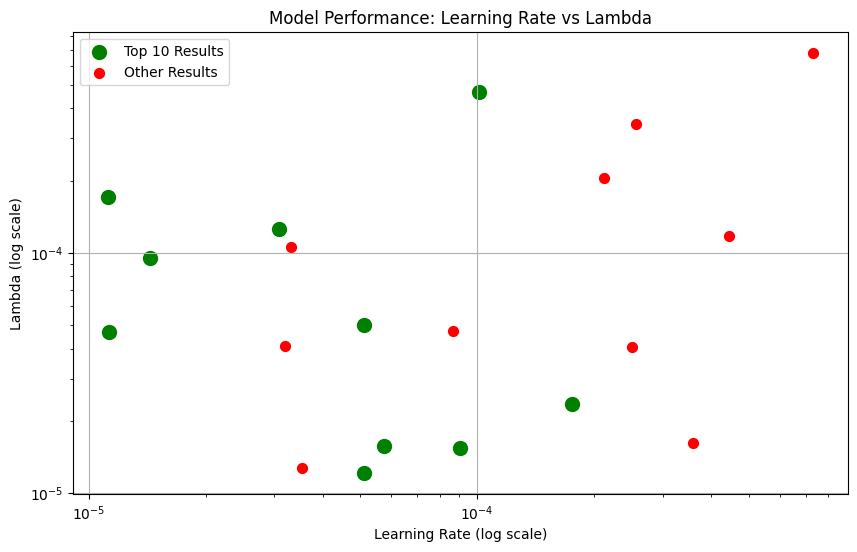

In [7]:
# Sort results by accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['acc'], reverse=True)

# Separate the 10 best results
best_results = sorted_results[:10]
other_results = sorted_results[10:]

# Prepare data for plotting
# Extract learning rates and lambdas
learning_rates_best = [r['learning_rate'] for r in best_results]
lambdas_best = [r['lambda'] for r in best_results]
accuracy_best = [r['acc'] for r in best_results]

learning_rates_other = [r['learning_rate'] for r in other_results]
lambdas_other = [r['lambda'] for r in other_results]
accuracy_other = [r['acc'] for r in other_results]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the 10 best results in green
plt.scatter(learning_rates_best, lambdas_best, c='green', s=100, label='Top 10 Results')
# Plot the other results in red
plt.scatter(learning_rates_other, lambdas_other, c='red', s=50, label='Other Results')

# Set plot attributes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Lambda (log scale)')
plt.title('Model Performance: Learning Rate vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
best_result = max(results, key=lambda x: x['acc'])
print(best_result)

{'learning_rate': 1.4359146006267404e-05, 'lambda': 9.538971603227724e-05, 'loss': 0.6811870336532593, 'acc': 0.809694766998291}


In [2]:
lambda_ = 1.44e-05
learning_rate = 9.54e-05

In [3]:
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train_set, validation_data=test_set, epochs=10, verbose=2)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/10


I0000 00:00:1734831773.818621     396 cuda_dnn.cc:529] Loaded cuDNN version 90300


70/70 - 40s - 573ms/step - accuracy: 0.6174 - loss: 0.6594 - precision: 0.6056 - recall: 0.6733 - val_accuracy: 0.5628 - val_loss: 0.7611 - val_precision: 0.7273 - val_recall: 0.2011
Epoch 2/10
70/70 - 15s - 211ms/step - accuracy: 0.7127 - loss: 0.5584 - precision: 0.6773 - recall: 0.8125 - val_accuracy: 0.7181 - val_loss: 0.5733 - val_precision: 0.7246 - val_recall: 0.7038
Epoch 3/10
70/70 - 14s - 205ms/step - accuracy: 0.7684 - loss: 0.4756 - precision: 0.7533 - recall: 0.7981 - val_accuracy: 0.7316 - val_loss: 0.5689 - val_precision: 0.6792 - val_recall: 0.8779
Epoch 4/10
70/70 - 14s - 196ms/step - accuracy: 0.7916 - loss: 0.4401 - precision: 0.7818 - recall: 0.8089 - val_accuracy: 0.7298 - val_loss: 0.5501 - val_precision: 0.6899 - val_recall: 0.8348
Epoch 5/10
70/70 - 13s - 191ms/step - accuracy: 0.8161 - loss: 0.4024 - precision: 0.8086 - recall: 0.8283 - val_accuracy: 0.7253 - val_loss: 0.5692 - val_precision: 0.6685 - val_recall: 0.8941
Epoch 6/10
70/70 - 14s - 193ms/step - acc

In [4]:
model.save('modeloCardio.keras')

In [5]:
lambda_ = lambda_ = 1.44e-01
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(train_set, validation_data=test_set, epochs=10, verbose=2)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/10
70/70 - 34s - 485ms/step - accuracy: 0.5023 - loss: 47.3676 - precision_9: 0.5025 - recall_9: 0.4547 - val_accuracy: 0.5144 - val_loss: 41.0487 - val_precision_9: 0.5081 - val_recall_9: 0.8959
Epoch 2/10
70/70 - 13s - 180ms/step - accuracy: 0.5128 - loss: 36.1519 - precision_9: 0.5123 - recall_9: 0.5340 - val_accuracy: 0.5197 - val_loss: 31.5446 - val_precision_9: 0.5107 - val_recall_9: 0.9425
Epoch 3/10
70/70 - 13s - 180ms/step - accuracy: 0.5338 - loss: 27.9928 - precision_9: 0.5274 - recall_9: 0.6507 - val_accuracy: 0.5386 - val_loss: 24.6491 - val_precision_9: 0.5210 - val_recall_9: 0.9587
Epoch 4/10
70/70 - 13s - 191ms/step - accuracy: 0.5719 - loss: 22.0601 - precision_9: 0.5602 - recall_9: 0.6692 - val_accuracy: 0.5090 - val_loss: 19.6278 - val_precision_9: 0.5046 - val_recall_9: 0.9856
Epoch 5/10
70/70 - 14s - 198ms/step - accuracy: 0.6541 - loss: 17.7212 - precision_9: 0.6513 - recall_9: 0.6634 - val_accuracy: 0.5969 - val_loss: 15.9421 - val_precision_9: 0.5587 - v

In [6]:
lambda_ = lambda_ = 1.44e-01
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(train_set, validation_data=test_set, epochs=10, verbose=2)
test_loss, test_acc, test_prec, test_re = model.evaluate(test_set, verbose=2)

Epoch 1/10
70/70 - 32s - 451ms/step - accuracy: 0.6163 - loss: 51.0085 - precision_10: 0.6239 - recall_10: 0.5854 - val_accuracy: 0.6472 - val_loss: 45.2004 - val_precision_10: 0.5889 - val_recall_10: 0.9749
Epoch 2/10
70/70 - 14s - 196ms/step - accuracy: 0.6737 - loss: 40.4497 - precision_10: 0.6928 - recall_10: 0.6242 - val_accuracy: 0.7720 - val_loss: 35.8120 - val_precision_10: 0.7496 - val_recall_10: 0.8169
Epoch 3/10
70/70 - 14s - 198ms/step - accuracy: 0.7210 - loss: 32.1316 - precision_10: 0.7650 - recall_10: 0.6381 - val_accuracy: 0.7460 - val_loss: 28.5832 - val_precision_10: 0.6963 - val_recall_10: 0.8725
Epoch 4/10
70/70 - 14s - 195ms/step - accuracy: 0.7287 - loss: 25.8041 - precision_10: 0.7998 - recall_10: 0.6102 - val_accuracy: 0.7558 - val_loss: 23.1412 - val_precision_10: 0.8306 - val_recall_10: 0.6427
Epoch 5/10
70/70 - 14s - 199ms/step - accuracy: 0.7546 - loss: 21.0304 - precision_10: 0.8416 - recall_10: 0.6273 - val_accuracy: 0.7756 - val_loss: 19.0294 - val_preci

In [ ]:
test_f1_score = 2 / ((1/test_precision) + (1 / test_recall))
print(test_f1_score)

Um F1 score de 80% foi atingido, o que é um bom resultado preliminar. Se tivermos um paciente que tem a doença, a probabilidade do seu diagnóstico ser positivo por esse modelo é de 90% (recall), o que indica que o teste fornece poucos falsos negativos. Entretanto, a precisão do modelo é de apenas 71%, o que implica que, caso o teste seja positivo, a probabilidade de não se ter a doença ainda é de 29%, o que é relativamente alto.

In [9]:
model.save('modeloCardio.keras')